# CAUSAL INFORMED PREDICTIVE MONITORING
---
## Dataset: BPI Challenge 2015_1

### imports

In [21]:
import pandas as pd
import missingno as msno
import causality
import elp
import os
import json

### load the data


In [22]:
log = pd.read_csv("../data/bpi2015_1.csv", sep=",", encoding="iso-8859-1")

/tmp/ipykernel_104151/4056567222.py:1: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  log = pd.read_csv("../data/bpi2015_1.csv", sep=",", encoding="iso-8859-1")


In [23]:
log.head()

,case,event,startTime,completeTime,termName,startDate,caseProcedure,Responsible_actor,caseStatus,Includes_subCases,...,org:resource,activityNameEN,action_code,activityNameNL,planned,dateStop,dateFinished,question,dueDate,monitoringResource
0,10009138,01_HOOFD_010,2014/04/11 00:00:00.000,2014/04/11 00:00:00.000,Termijn bezwaar en beroep 1,2014/04/11 00:00:00.000,NaN,560464.0,O,NaN,...,9264148,register submission date request,01_HOOFD_010,registratie datum binnenkomst aanvraag,2014/04/15 09:30:39.000,NaN,2014-04-14 00:00:00,EMPTY,2014/04/17 09:30:39.000,2670601
1,10009138,01_HOOFD_011,2014/04/14 00:00:00.000,2014/04/14 00:00:00.000,Termijn bezwaar en beroep 1,2014/04/11 00:00:00.000,NaN,560464.0,O,NaN,...,9264148,OLO messaging active,01_HOOFD_011,OLO berichtenverkeer actief,2014/04/15 09:34:03.000,NaN,2014-04-14 00:00:00,False,2014/04/17 09:30:39.000,2670601
2,10009138,01_HOOFD_020,2014/04/14 00:00:00.000,2014/04/14 00:00:00.000,Termijn bezwaar en beroep 1,2014/04/11 00:00:00.000,NaN,560464.0,O,NaN,...,9264148,send confirmation receipt,01_HOOFD_020,versturen ontvangstbevestiging,2014/04/15 09:34:03.000,NaN,2014-04-14 00:00:00,True,2014/04/17 09:30:39.000,2670601
3,10009138,02_DRZ_010,2014/04/14 00:00:00.000,2014/04/14 00:00:00.000,Termijn bezwaar en beroep 1,2014/04/11 00:00:00.000,NaN,560464.0,O,NaN,...,9264148,forward to the competent authority,02_DRZ_010,doorsturen aan bevoegd gezag,2014/04/15 09:37:17.000,NaN,2014-04-14 00:00:00,False,2014/04/21 09:37:17.000,2670601
4,10009138,04_BPT_005,2014/04/14 00:00:00.000,2014/04/14 00:00:00.000,Termijn bezwaar en beroep 1,2014/04/11 00:00:00.000,NaN,560464.0,O,NaN,...,9264148,regular procedure without MER,04_BPT_005,reguliere procedure zonder MER,2014/04/15 09:37:22.000,NaN,2014-04-14 00:00:00,True,2014/04/21 09:37:17.000,2670601


In [24]:
log.describe()

,case,Responsible_actor,landRegisterID,SUMleges,case_type,IDofConceptCase,org:resource,monitoringResource
count,5.221700e+04,5.219800e+04,8.007000e+03,43585.000000,52217.0,3.583600e+04,5.221700e+04,5.221700e+04
mean,6.457442e+06,2.708113e+06,5.755311e+06,2360.950299,557669.0,6.774428e+06,1.930770e+06,1.979146e+06
std,2.900878e+06,2.157719e+06,3.904808e+06,5098.837046,0.0,2.876801e+06,2.318161e+06,1.404687e+06
min,2.742737e+06,5.604620e+05,7.150300e+05,-2234.540000,557669.0,2.760933e+06,6.000000e+00,6.000000e+00
25%,3.862810e+06,5.604640e+05,3.245444e+06,217.030350,557669.0,4.343382e+06,5.608720e+05,5.608900e+05
50%,5.829130e+06,2.670601e+06,5.107386e+06,536.274500,557669.0,6.225448e+06,5.609120e+05,2.670601e+06
75%,8.723873e+06,4.901428e+06,9.011175e+06,1920.606900,557669.0,9.047782e+06,2.670601e+06,3.273854e+06
max,1.316658e+07,1.071607e+07,1.281432e+07,104549.700000,557669.0,1.316672e+07,1.294173e+07,1.294173e+07


<Axes: >

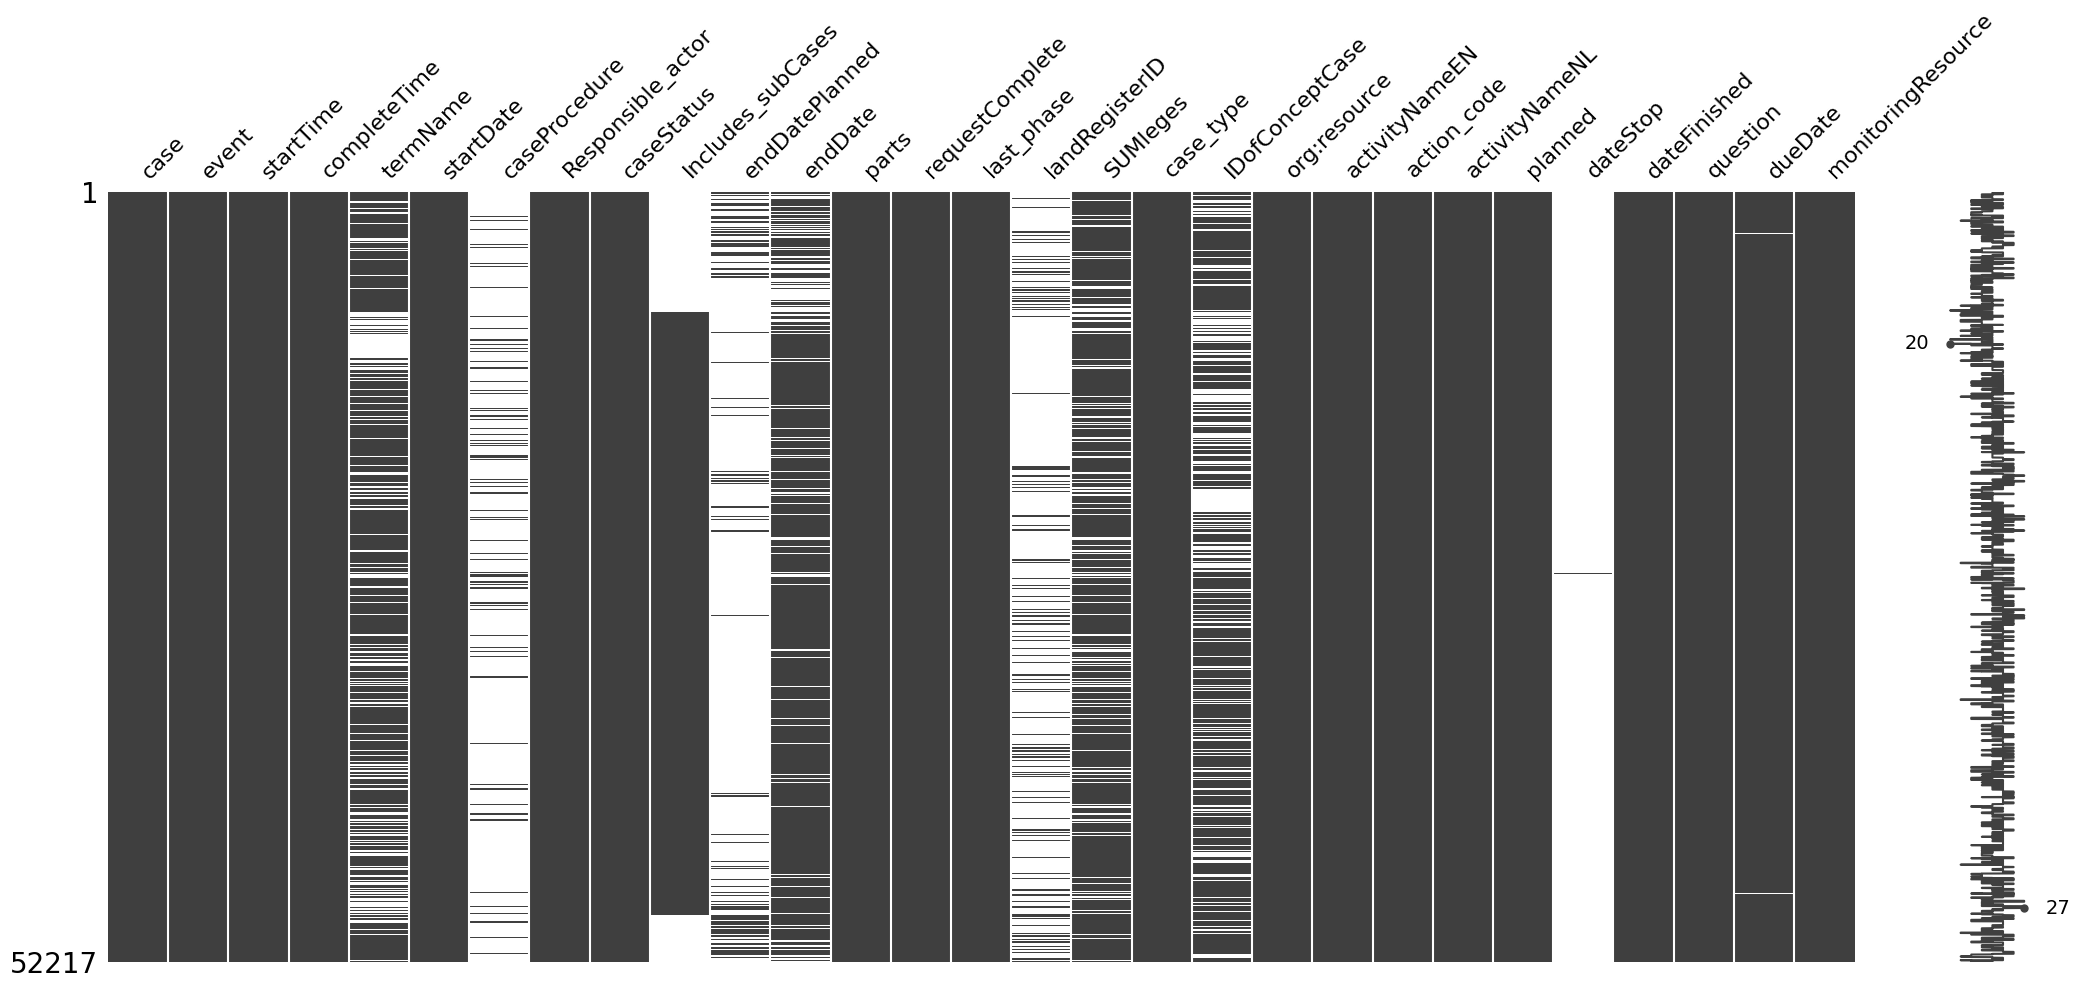

In [25]:
msno.matrix(log)

In [26]:
log.fillna("UNKNOWN", inplace=True)

/tmp/ipykernel_104151/2811332286.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'UNKNOWN' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  log.fillna("UNKNOWN", inplace=True)


<Axes: >

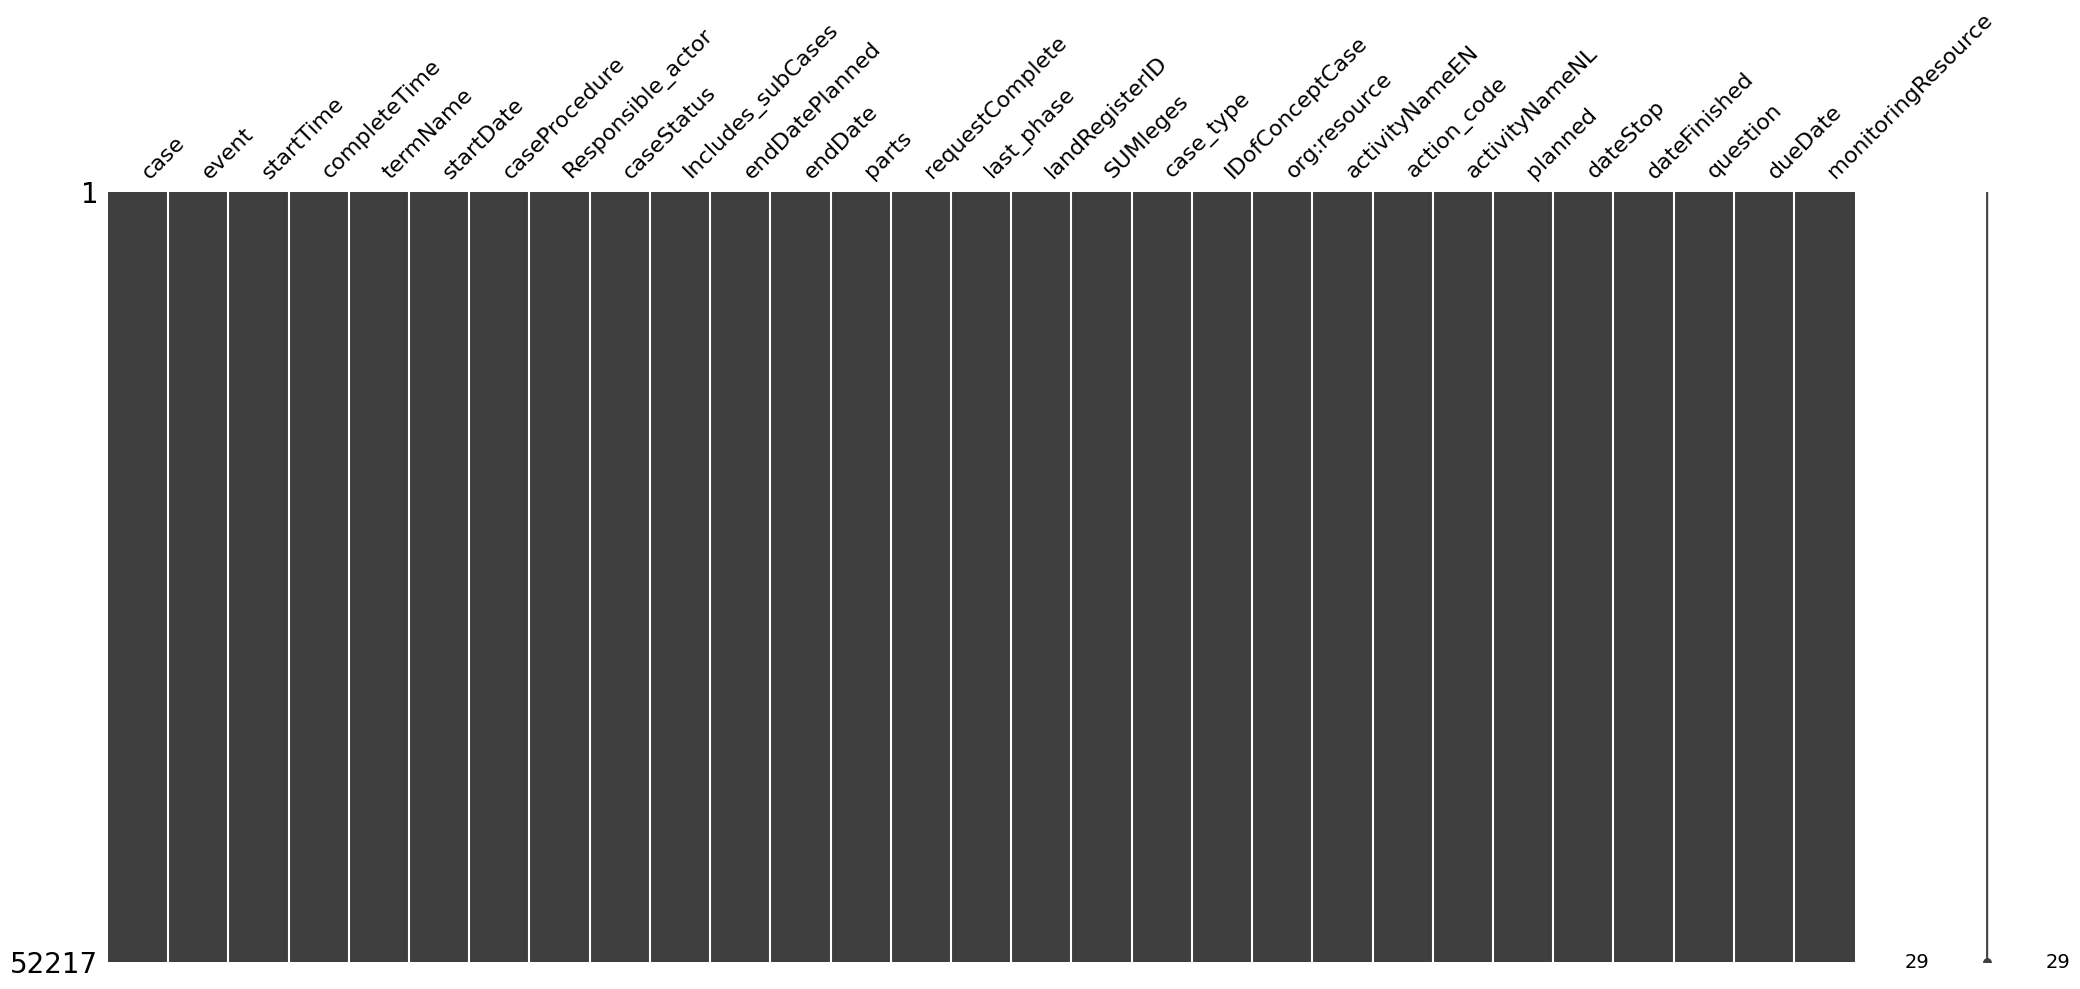

In [27]:
msno.matrix(log)

In [28]:
log.rename(columns={"case": "id", "completeTime": "timestamp"}, inplace=True)

In [29]:
log

,id,event,startTime,timestamp,termName,startDate,caseProcedure,Responsible_actor,caseStatus,Includes_subCases,...,org:resource,activityNameEN,action_code,activityNameNL,planned,dateStop,dateFinished,question,dueDate,monitoringResource
0,10009138,01_HOOFD_010,2014/04/11 00:00:00.000,2014/04/11 00:00:00.000,Termijn bezwaar en beroep 1,2014/04/11 00:00:00.000,UNKNOWN,560464.0,O,UNKNOWN,...,9264148,register submission date request,01_HOOFD_010,registratie datum binnenkomst aanvraag,2014/04/15 09:30:39.000,UNKNOWN,2014-04-14 00:00:00,EMPTY,2014/04/17 09:30:39.000,2670601
1,10009138,01_HOOFD_011,2014/04/14 00:00:00.000,2014/04/14 00:00:00.000,Termijn bezwaar en beroep 1,2014/04/11 00:00:00.000,UNKNOWN,560464.0,O,UNKNOWN,...,9264148,OLO messaging active,01_HOOFD_011,OLO berichtenverkeer actief,2014/04/15 09:34:03.000,UNKNOWN,2014-04-14 00:00:00,False,2014/04/17 09:30:39.000,2670601
2,10009138,01_HOOFD_020,2014/04/14 00:00:00.000,2014/04/14 00:00:00.000,Termijn bezwaar en beroep 1,2014/04/11 00:00:00.000,UNKNOWN,560464.0,O,UNKNOWN,...,9264148,send confirmation receipt,01_HOOFD_020,versturen ontvangstbevestiging,2014/04/15 09:34:03.000,UNKNOWN,2014-04-14 00:00:00,True,2014/04/17 09:30:39.000,2670601
3,10009138,02_DRZ_010,2014/04/14 00:00:00.000,2014/04/14 00:00:00.000,Termijn bezwaar en beroep 1,2014/04/11 00:00:00.000,UNKNOWN,560464.0,O,UNKNOWN,...,9264148,forward to the competent authority,02_DRZ_010,doorsturen aan bevoegd gezag,2014/04/15 09:37:17.000,UNKNOWN,2014-04-14 00:00:00,False,2014/04/21 09:37:17.000,2670601
4,10009138,04_BPT_005,2014/04/14 00:00:00.000,2014/04/14 00:00:00.000,Termijn bezwaar en beroep 1,2014/04/11 00:00:00.000,UNKNOWN,560464.0,O,UNKNOWN,...,9264148,regular procedure without MER,04_BPT_005,reguliere procedure zonder MER,2014/04/15 09:37:22.000,UNKNOWN,2014-04-14 00:00:00,True,2014/04/21 09:37:17.000,2670601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52212,9996445,01_HOOFD_495,2014/07/11 00:00:00.000,2014/07/11 00:00:00.000,Termijn bezwaar en beroep 1,2014/04/10 00:00:00.000,UNKNOWN,560912.0,O,UNKNOWN,...,560890,phase decision taken,01_HOOFD_495,fase besluit genomen,2014/07/14 10:14:15.000,UNKNOWN,2014-07-11 00:00:00,EMPTY,2014/04/18 11:34:17.000,560890
52213,9996445,01_HOOFD_490_5,2014/07/17 00:00:00.000,2014/07/17 00:00:00.000,Termijn bezwaar en beroep 1,2014/04/10 00:00:00.000,UNKNOWN,560912.0,O,UNKNOWN,...,560890,record date of decision environmental permit,01_HOOFD_490_5,registreren datum besluit omgevingsvergunning2,2014/07/10 15:50:01.000,UNKNOWN,2014-07-11 00:00:00,EMPTY,2014/04/18 11:34:17.000,2670601
52214,9996445,01_HOOFD_510_2a,2014/07/17 00:00:00.000,2014/07/17 00:00:00.000,Termijn bezwaar en beroep 1,2014/04/10 00:00:00.000,UNKNOWN,560912.0,O,UNKNOWN,...,560890,start decision phase decision permitting sent,01_HOOFD_510_2a,instellen besluitfase:besluit vergunnen verzonden,2014/07/14 10:17:55.000,UNKNOWN,2014-07-11 00:00:00,EMPTY,2014/04/18 11:34:17.000,560890
52215,9996445,01_HOOFD_490_5a,2014/07/17 00:00:00.000,2014/07/17 00:00:00.000,Termijn bezwaar en beroep 1,2014/04/10 00:00:00.000,UNKNOWN,560912.0,O,UNKNOWN,...,560890,set decision phase decision permitting decided,01_HOOFD_490_5a,instellen besluitfase:besluit vergunnen besloten,2014/07/14 10:14:12.000,UNKNOWN,2014-07-11 00:00:00,EMPTY,2014/04/18 11:34:17.000,560890


In [30]:
log["id"].describe()

count    5.221700e+04
mean     6.457442e+06
std      2.900878e+06
min      2.742737e+06
25%      3.862810e+06
50%      5.829130e+06
75%      8.723873e+06
max      1.316658e+07
Name: id, dtype: float64

In [31]:
log["timestamp"]

0        2014/04/11 00:00:00.000
1        2014/04/14 00:00:00.000
2        2014/04/14 00:00:00.000
3        2014/04/14 00:00:00.000
4        2014/04/14 00:00:00.000
                  ...           
52212    2014/07/11 00:00:00.000
52213    2014/07/17 00:00:00.000
52214    2014/07/17 00:00:00.000
52215    2014/07/17 00:00:00.000
52216    2014/07/17 00:00:00.000
Name: timestamp, Length: 52217, dtype: object

### preprocessing and encode

In [32]:
log = elp.EventLog(log, "id", "timestamp")

/home/ppibot/Escritorio/causally-informed-prescriptive-monitoring-main/.venv/lib/python3.10/site-packages/elp/event_log.py:43: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  temp = pd.to_datetime(


In [33]:
log.df.columns

Index(['id', 'event', 'startTime', 'timestamp', 'termName', 'startDate',
       'caseProcedure', 'Responsible_actor', 'caseStatus', 'Includes_subCases',
       'endDatePlanned', 'endDate', 'parts', 'requestComplete', 'last_phase',
       'landRegisterID', 'SUMleges', 'case_type', 'IDofConceptCase',
       'org:resource', 'activityNameEN', 'action_code', 'activityNameNL',
       'planned', 'dateStop', 'dateFinished', 'question', 'dueDate',
       'monitoringResource'],
      dtype='object')

In [34]:
log.df.head()

,id,event,startTime,timestamp,termName,startDate,caseProcedure,Responsible_actor,caseStatus,Includes_subCases,...,org:resource,activityNameEN,action_code,activityNameNL,planned,dateStop,dateFinished,question,dueDate,monitoringResource
0,2742737,01_HOOFD_010,2011/06/01 00:00:00.000,2011-06-01 00:00:00+00:00,UNKNOWN,2012/10/01 00:00:00.000,UNKNOWN,560464.0,O,J,...,560462,register submission date request,01_HOOFD_010,registratie datum binnenkomst aanvraag,2010/10/02 13:04:41.000,UNKNOWN,2011-06-16 12:19:47,1-6-2011 0:00:00,2010/10/04 13:04:41.000,560464
1,2742737,01_HOOFD_015,2011/06/16 12:17:11.000,2011-06-16 12:17:11+00:00,UNKNOWN,2012/10/01 00:00:00.000,UNKNOWN,560464.0,O,J,...,560462,phase application received,01_HOOFD_015,fase aanvraag ontvangen,2010/10/02 13:04:41.000,UNKNOWN,2011-06-16 12:19:47,EMPTY,2010/10/04 13:04:41.000,560464
2,2742737,01_HOOFD_020,2011/06/16 12:17:14.000,2011-06-16 12:17:14+00:00,UNKNOWN,2012/10/01 00:00:00.000,UNKNOWN,560464.0,O,J,...,560462,reception through OLO,01_HOOFD_020,ontvangst via OLO,2011/06/17 12:17:11.000,UNKNOWN,2011-06-16 12:19:47,True,2011/06/19 12:17:11.000,560464
3,2742737,01_HOOFD_040,2011/06/16 12:17:16.000,2011-06-16 12:17:16+00:00,UNKNOWN,2012/10/01 00:00:00.000,UNKNOWN,560464.0,O,J,...,560462,forward to the competent authority,01_HOOFD_040,doorsturen aan bevoegd gezag,2011/06/17 12:17:14.000,UNKNOWN,2011-06-16 12:19:47,False,2011/06/21 12:17:14.000,560464
4,2742737,01_HOOFD_050,2011/06/16 12:17:17.000,2011-06-16 12:17:17+00:00,UNKNOWN,2012/10/01 00:00:00.000,UNKNOWN,560464.0,O,J,...,560462,applicant is stakeholder,01_HOOFD_050,aanvrager is belanghebbende,2011/06/17 12:17:16.000,UNKNOWN,2011-06-16 12:19:47,True,2011/06/21 12:17:14.000,560464


In [35]:
colums_to_encode = list(log.df.select_dtypes(include="object").columns)
colums_to_encode.remove("Responsible_actor")
colums_to_encode.remove("landRegisterID")
colums_to_encode.remove("SUMleges")
colums_to_encode.remove("IDofConceptCase")
colums_to_encode.append("requestComplete")
print(colums_to_encode)

causality.label_encode(log.df, colums_to_encode)

log.df.head()

['event', 'startTime', 'termName', 'startDate', 'caseProcedure', 'caseStatus', 'Includes_subCases', 'endDatePlanned', 'endDate', 'parts', 'last_phase', 'activityNameEN', 'action_code', 'activityNameNL', 'planned', 'dateStop', 'dateFinished', 'question', 'dueDate', 'requestComplete']


,id,event,startTime,timestamp,termName,startDate,caseProcedure,Responsible_actor,caseStatus,Includes_subCases,...,org:resource,activityNameEN,action_code,activityNameNL,planned,dateStop,dateFinished,question,dueDate,monitoringResource
0,2742737,25,5256,2011-06-01 00:00:00+00:00,13,371,1,560464.0,1,0,...,560462,200,25,229,0,2,1182,10,0,560464
1,2742737,27,5523,2011-06-16 12:17:11+00:00,13,371,1,560464.0,1,0,...,560462,151,27,120,0,2,1182,409,0,560464
2,2742737,28,5524,2011-06-16 12:17:14+00:00,13,371,1,560464.0,1,0,...,560462,190,28,209,5642,2,1182,417,1072,560464
3,2742737,31,5525,2011-06-16 12:17:16+00:00,13,371,1,560464.0,1,0,...,560462,116,31,115,5643,2,1182,411,1080,560464
4,2742737,32,5526,2011-06-16 12:17:17+00:00,13,371,1,560464.0,1,0,...,560462,12,32,27,5644,2,1182,417,1080,560464


In [36]:
import elp.encoders as en

encoder = en.LogEncoder(
    transformers=[
        ("drop", "drop", ["id"]),
        (
            "keep",
            "keep",
            [
                "termName",
                "startDate",
                "caseProcedure",
                "caseStatus",
                "Includes_subCases",
                "endDatePlanned",
                "endDate",
                "parts",
                "requestComplete",
                "last_phase",
                "case_type",
                "event",
                "activityNameEN",
                "action_code",
                "activityNameNL",
                "planned",
                "question",
                "monitoringResource",
            ],
        ),
        (
            "timestamp",
            en.TimestampFeatures(
                log.id_column,
                [
                    "event_order",
                    "time_from_start",
                    "time_from_midnight",
                    "total_time",
                    "elapsed_time_from_event",
                ],
                unit="1h",
            ),
            [log.timestamp_column],
        ),
    ]
)

encoder.check_unused(log)

['startTime',
 'Responsible_actor',
 'landRegisterID',
 'SUMleges',
 'IDofConceptCase',
 'org:resource',
 'dateStop',
 'dateFinished',
 'dueDate']

In [37]:
dataset = encoder.fit_transform(log)

Fitting drop
Fitting keep
Fitting timestamp
Transforming drop
Transforming keep
Transforming timestamp


In [38]:
dataset

,termName,startDate,caseProcedure,caseStatus,Includes_subCases,endDatePlanned,endDate,parts,requestComplete,last_phase,...,action_code,activityNameNL,planned,question,monitoringResource,event_order_timestamp,time_from_start_timestamp,time_from_midnight_timestamp,total_time_timestamp,elapsed_time_from_event_timestamp
0,13,371,1,1,0,25,478,17,1,1,...,25,229,0,10,560464,0,0.000000,0.000000,372.29,0.000000
1,13,371,1,1,0,25,478,17,1,1,...,27,120,0,409,560464,1,372.286389,12.286389,372.29,372.286389
2,13,371,1,1,0,25,478,17,1,1,...,28,209,5642,417,560464,2,372.287222,12.287222,372.29,0.000833
3,13,371,1,1,0,25,478,17,1,1,...,31,115,5643,411,560464,3,372.287778,12.287778,372.29,0.000556
4,13,371,1,1,0,25,478,17,1,1,...,32,27,5644,417,560464,4,372.288056,12.288056,372.29,0.000278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52212,7,739,1,1,2,86,478,44,1,1,...,29,272,38816,409,560890,6,0.000000,0.000000,24.00,0.000000
52213,7,739,1,1,2,86,478,44,1,1,...,25,229,38814,409,12941730,7,0.000000,0.000000,24.00,0.000000
52214,7,739,1,1,2,86,478,44,1,1,...,27,120,38815,409,560890,8,0.000000,0.000000,24.00,0.000000
52215,7,739,1,1,2,86,478,44,1,1,...,35,7,38819,409,560890,9,0.000000,0.000000,24.00,0.000000


### run base experiment

Split 0: 8707 train rows, 8702 test rows
{'mse': 361203.6467494534,
 'rmse': 601.0022019505864,
 'split': 0,
 'time': 0.44629406929016113}


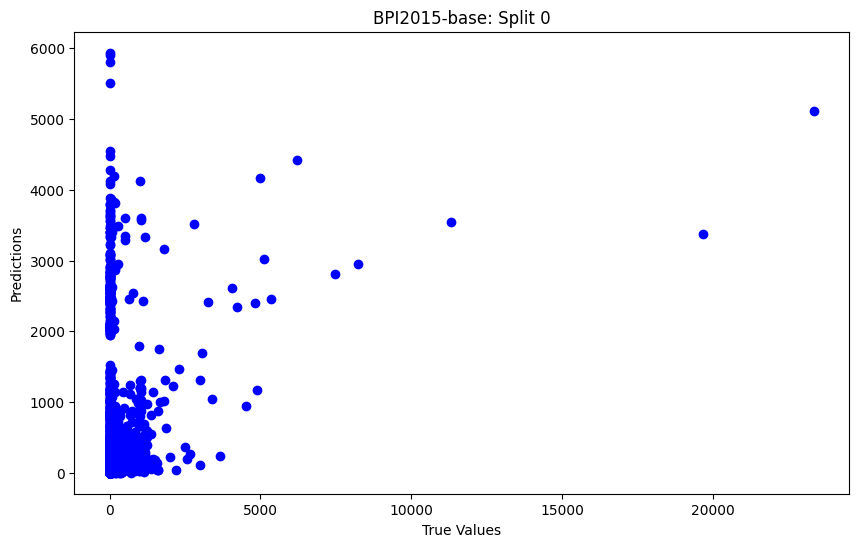

Split 1: 17409 train rows, 8702 test rows
{'mse': 439592.2314935998,
 'rmse': 663.017519748611,
 'split': 1,
 'time': 1.0281004905700684}


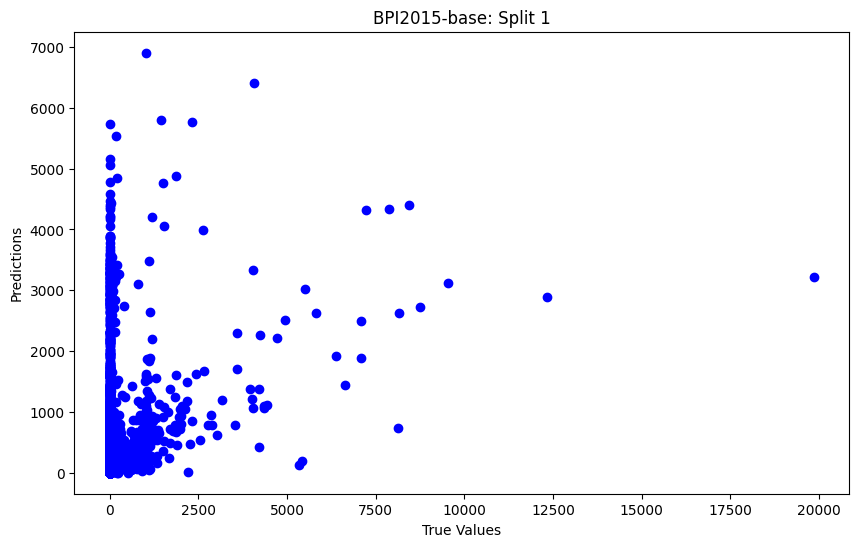

Split 2: 26111 train rows, 8702 test rows
{'mse': 627692.4403691825,
 'rmse': 792.2704338602965,
 'split': 2,
 'time': 1.5627284049987793}


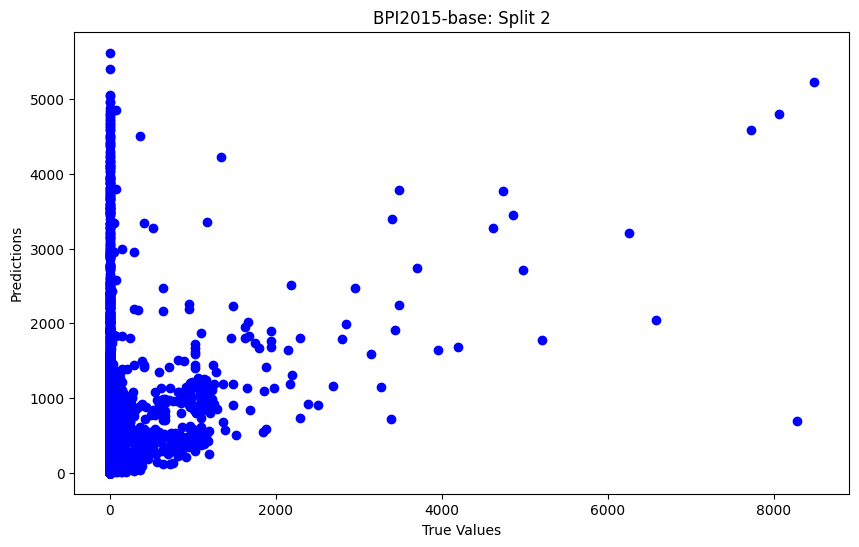

Split 3: 34813 train rows, 8702 test rows
{'mse': 269628.11404348037,
 'rmse': 519.2572715364518,
 'split': 3,
 'time': 2.0315134525299072}


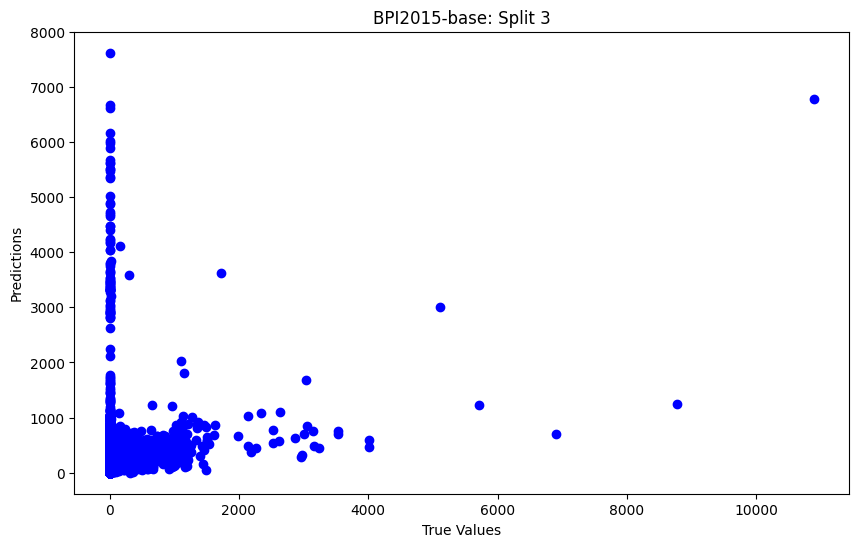

Split 4: 43515 train rows, 8702 test rows
{'mse': 47238.58642092591,
 'rmse': 217.34439588111286,
 'split': 4,
 'time': 2.4532454013824463}


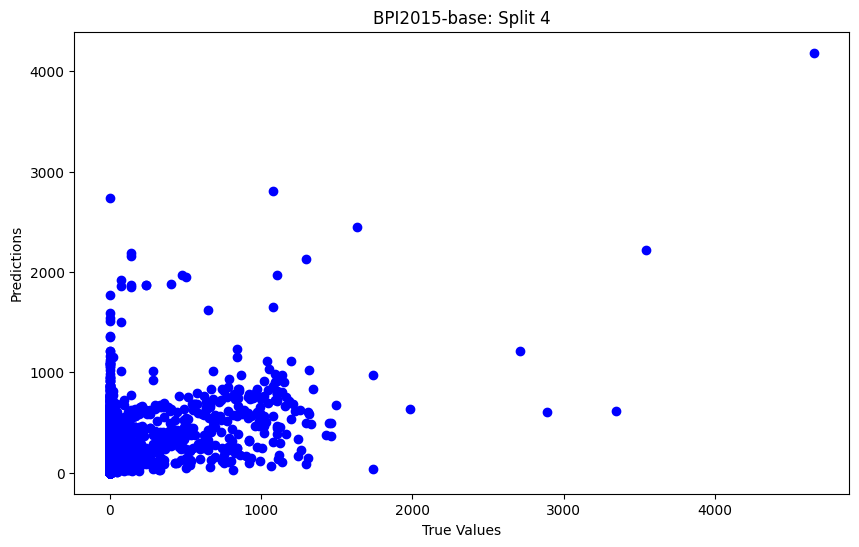

{'mse': 349071.00381532835, 'rmse': 558.5783645954118}


In [39]:
results_base = causality.run_experiment(
    dataset,
    target="elapsed_time_from_event_timestamp",
    name="BPI2015",
    experiment="base",
)

### causal inference and causal informed prediction

/home/ppibot/Escritorio/causally-informed-prescriptive-monitoring-main/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/ppibot/Escritorio/causally-informed-prescriptive-monitoring-main/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
Depth=0, working on node 22: 100%|██████████| 23/23 [00:00<00:00, 660.37it/s]


X8 --> X1
X10 --> X2
X2 --> X16
X16 --> X4
X17 --> X13
X16 --> X21
X20 --> X22


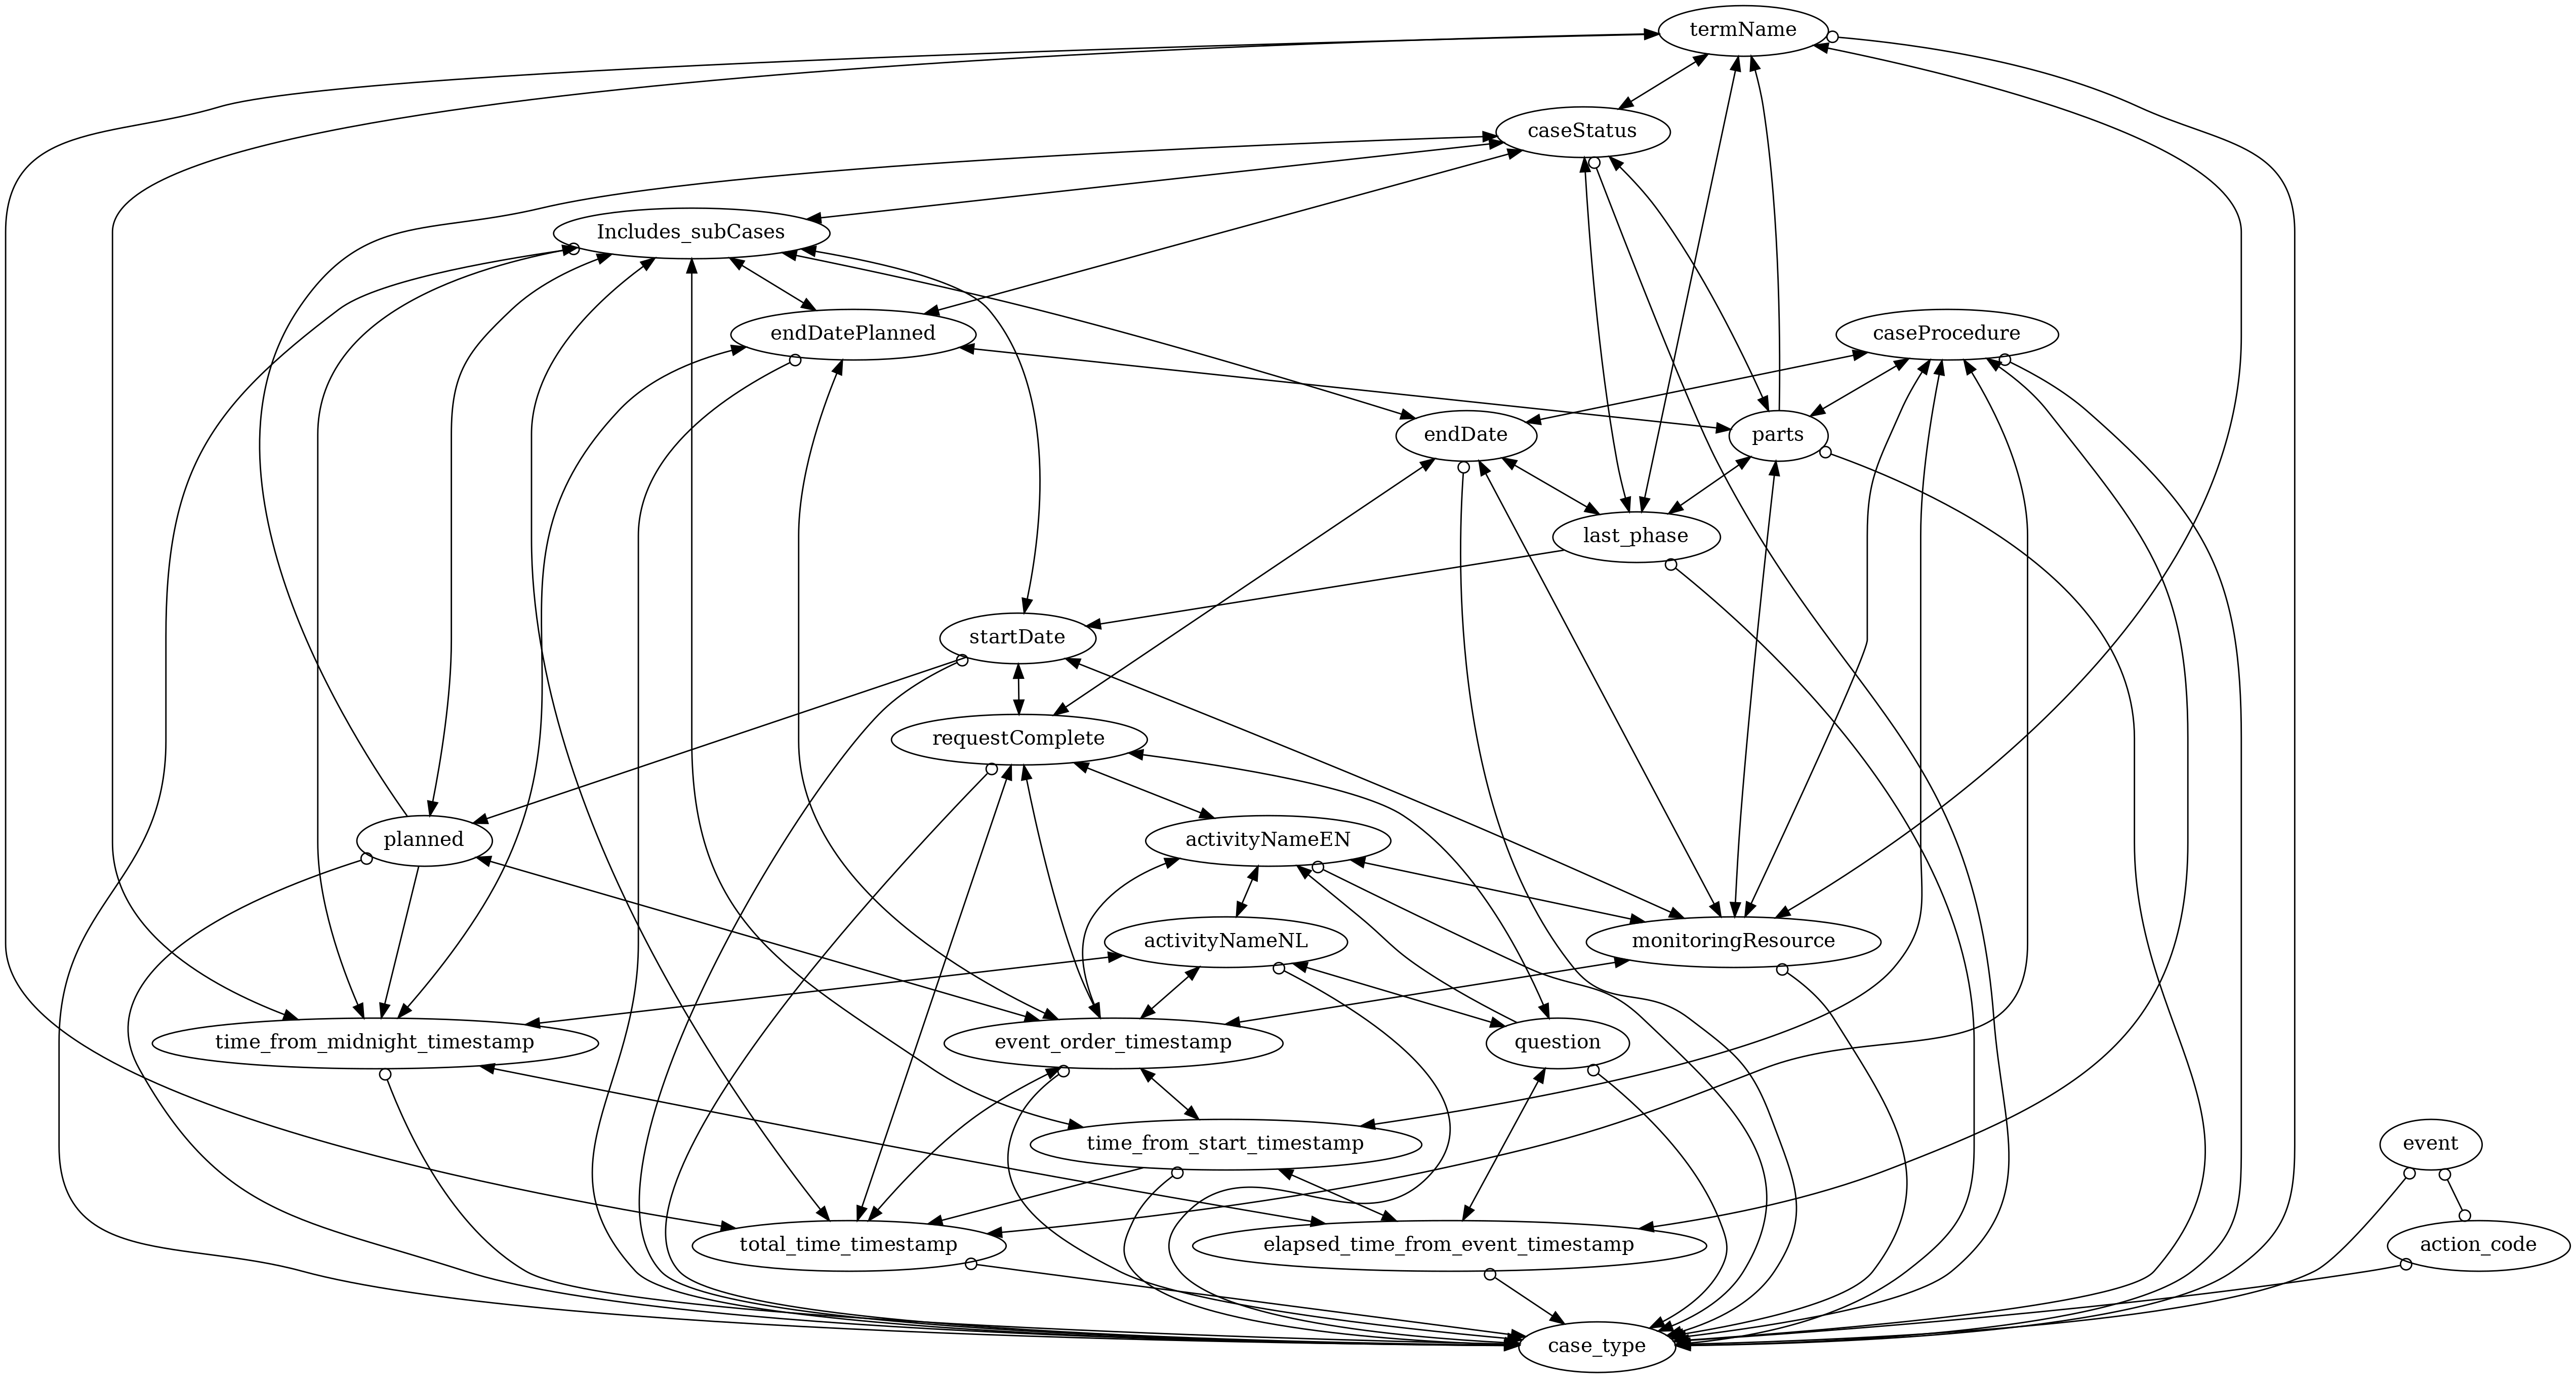

In [40]:
graph = causality.causal_inference_fci(dataset, "BPI2015")

In [41]:
parents = [
    "caseProcedure",
    "question",
    "time_from_start_timestamp",
    "time_from_midnight_timestamp",
]
parents_of_parents = {
    "caseProcedure": [
        "monitoringResource",
        "parts",
        "endDate",
        "total_time_timestamp",
    ],
    "question": [
        "activityNameNL",
    ],
    "time_from_start_timestamp": [
        "Includes_subCases",
    ],
    "time_from_midnight_timestamp": ["endDatePlanned", "termName"],
}
parents_2_order = list(parents_of_parents.keys()) + [
    item for sublist in parents_of_parents.values() for item in sublist
]

### run only 1 order parents experiment

/home/ppibot/Escritorio/causally-informed-prescriptive-monitoring-main/experiments/causality.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(columns=[target], inplace=True)


Split 0: 8707 train rows, 8702 test rows
{'mse': 229297.68785394676,
 'rmse': 478.8503814908648,
 'split': 0,
 'time': 0.15058612823486328}


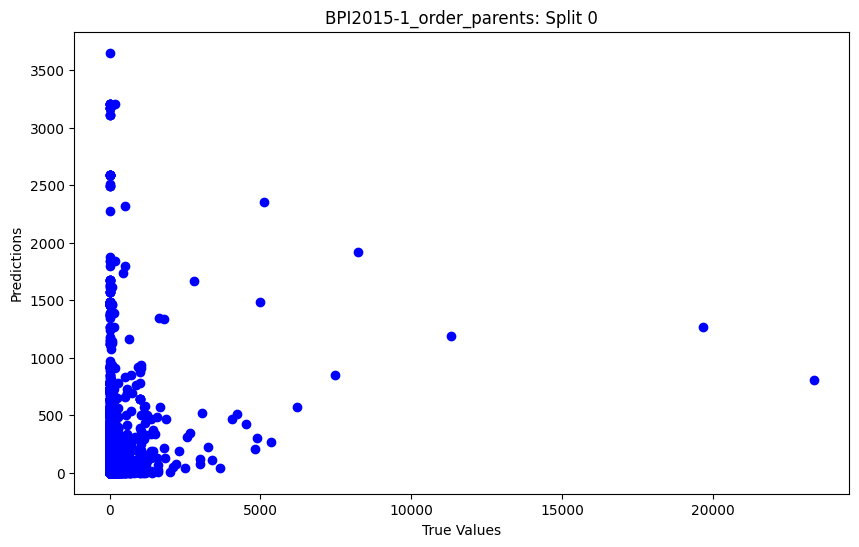

Split 1: 17409 train rows, 8702 test rows
{'mse': 344320.76546816144,
 'rmse': 586.788518521078,
 'split': 1,
 'time': 0.25624871253967285}


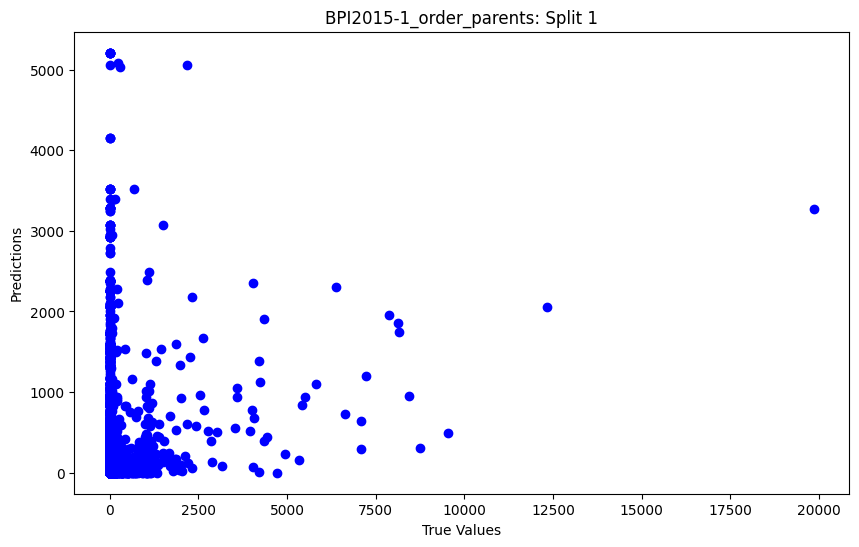

Split 2: 26111 train rows, 8702 test rows
{'mse': 367866.70080656244,
 'rmse': 606.5201569664132,
 'split': 2,
 'time': 0.39080047607421875}


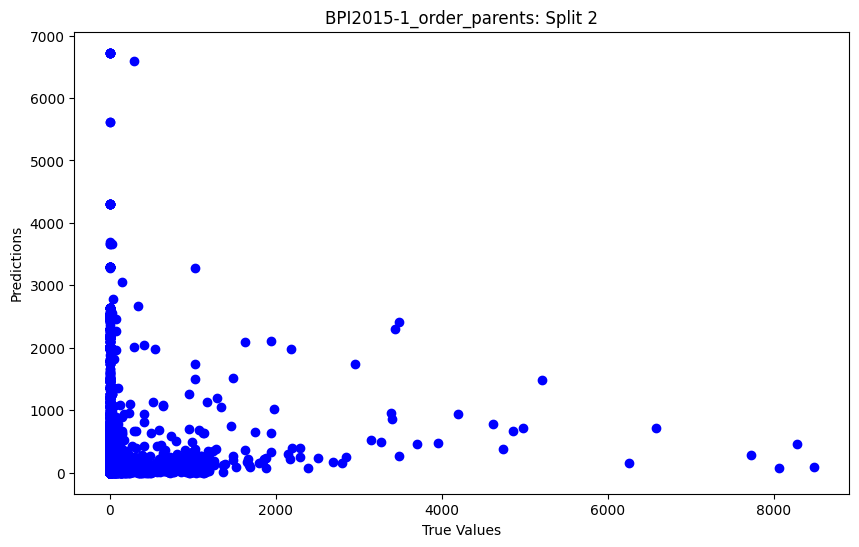

Split 3: 34813 train rows, 8702 test rows
{'mse': 125508.94283074903,
 'rmse': 354.27241330754083,
 'split': 3,
 'time': 0.5002248287200928}


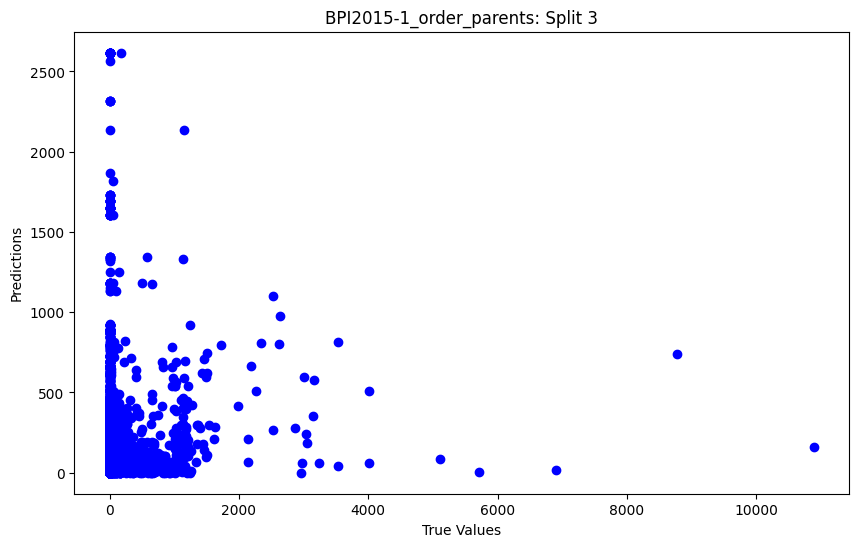

Split 4: 43515 train rows, 8702 test rows
{'mse': 63049.1149231336,
 'rmse': 251.09582816752174,
 'split': 4,
 'time': 0.512810468673706}


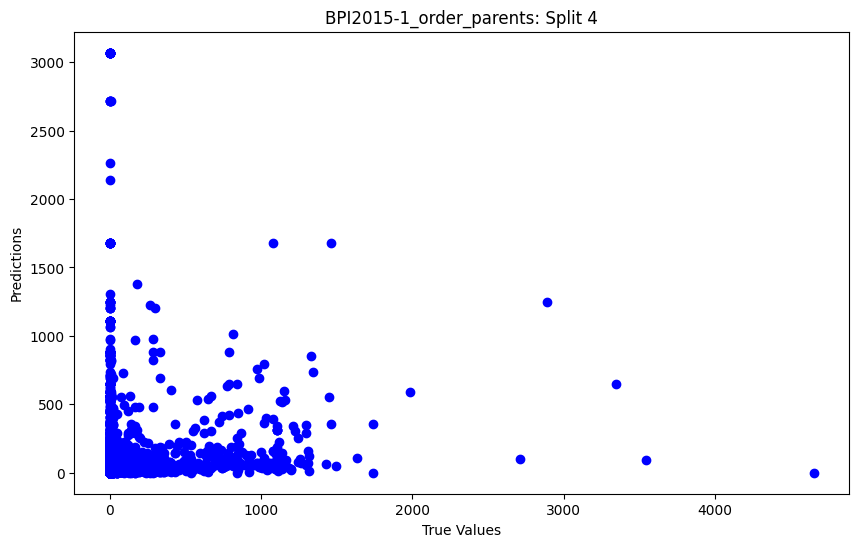

{'mse': 226008.6423765106, 'rmse': 455.5054596906837}


In [42]:
columns = parents + ["elapsed_time_from_event_timestamp"]

results_1_order_parents = causality.run_experiment(
    dataset,
    target="elapsed_time_from_event_timestamp",
    name="BPI2015",
    experiment="1_order_parents",
    columns=columns,
)

### run without parents experiments

Split 0: 8707 train rows, 8702 test rows


/home/ppibot/Escritorio/causally-informed-prescriptive-monitoring-main/experiments/causality.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(columns=[target], inplace=True)


{'mse': 265955.48562908266,
 'rmse': 515.7087216918894,
 'split': 0,
 'time': 0.2876431941986084}


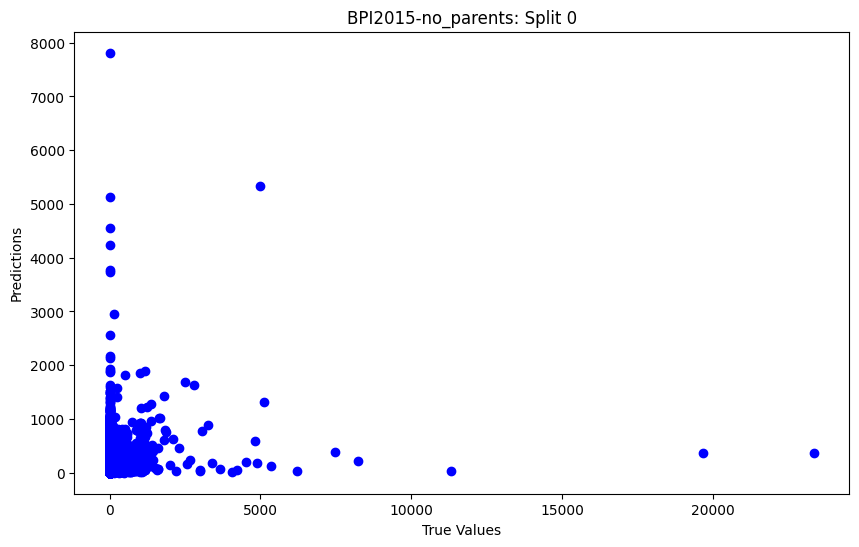

Split 1: 17409 train rows, 8702 test rows
{'mse': 1423274.0392564256,
 'rmse': 1193.010494193754,
 'split': 1,
 'time': 0.6029601097106934}


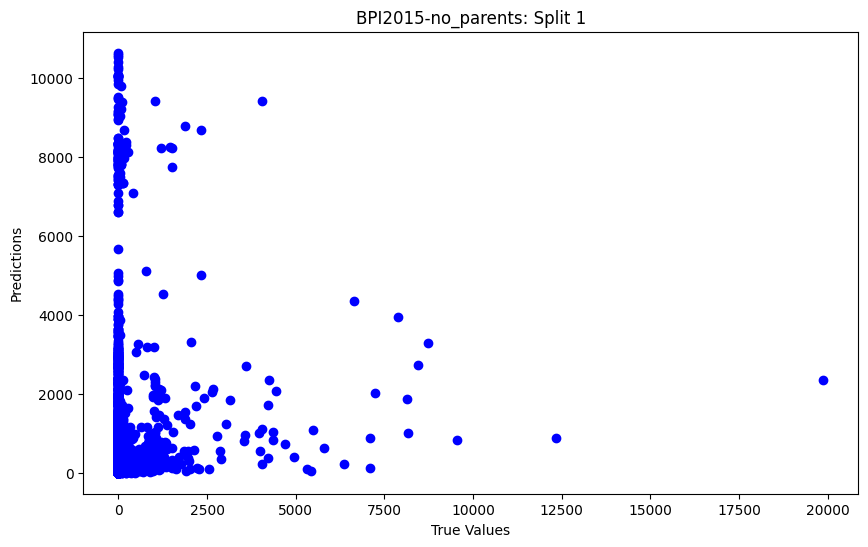

Split 2: 26111 train rows, 8702 test rows
{'mse': 280379.3104608148,
 'rmse': 529.5085556068143,
 'split': 2,
 'time': 1.0746276378631592}


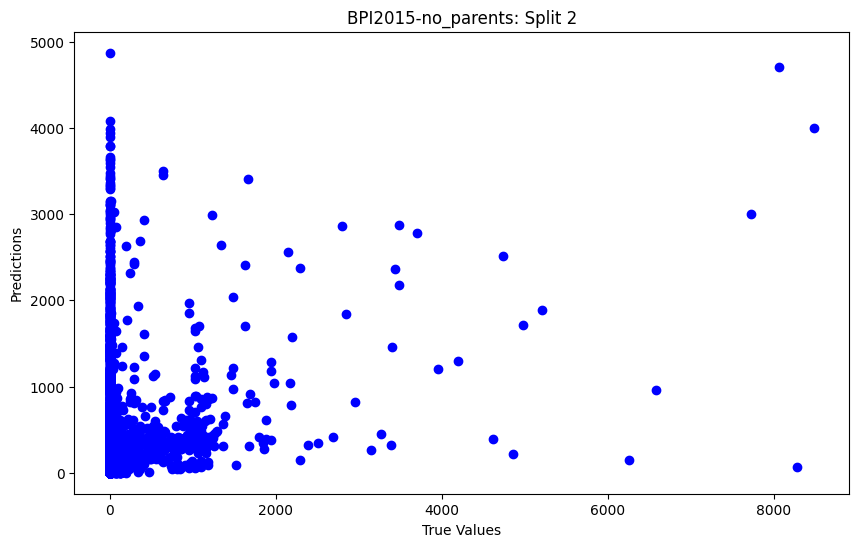

Split 3: 34813 train rows, 8702 test rows
{'mse': 507166.06986987445,
 'rmse': 712.1559308675836,
 'split': 3,
 'time': 1.2471530437469482}


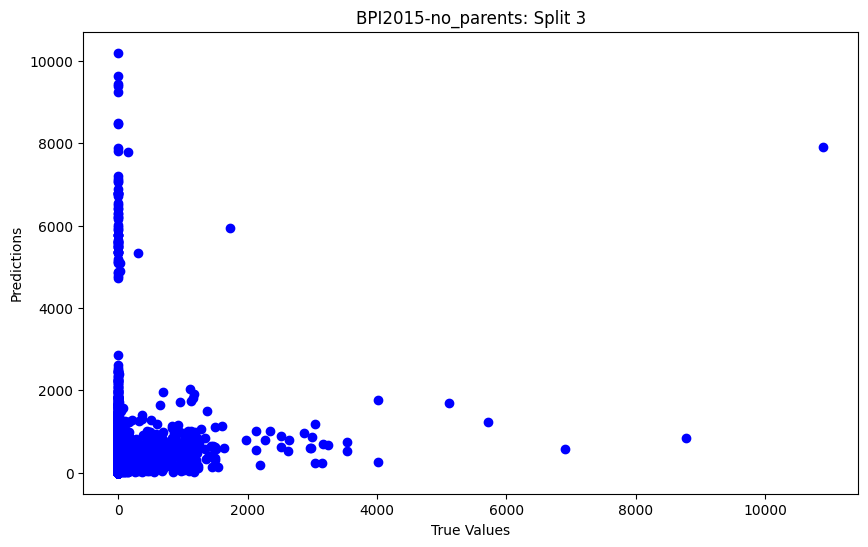

Split 4: 43515 train rows, 8702 test rows
{'mse': 155617.76491385957,
 'rmse': 394.4841757458207,
 'split': 4,
 'time': 1.6107263565063477}


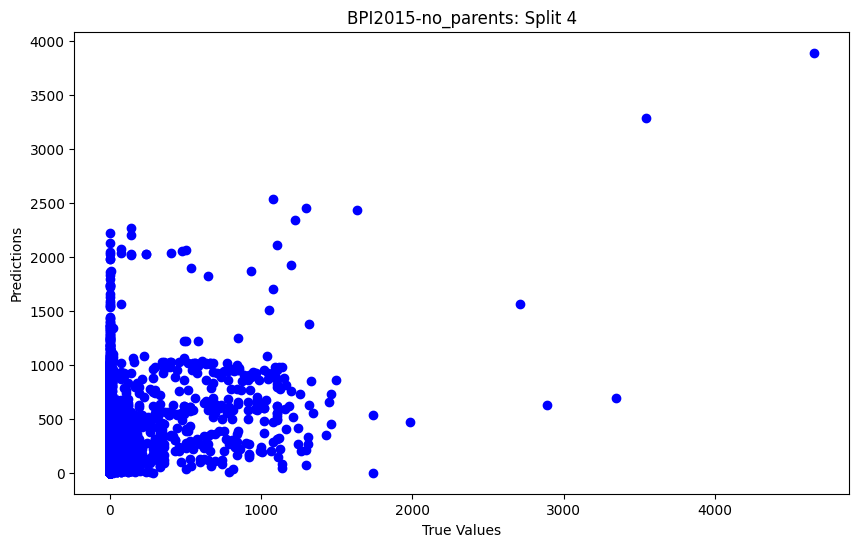

{'mse': 526478.5340260115, 'rmse': 668.9735756211724}


In [43]:
columns = filter(lambda i: i not in parents, dataset.columns.tolist())

results_no_parents = causality.run_experiment(
    dataset,
    target="elapsed_time_from_event_timestamp",
    name="BPI2015",
    experiment="no_parents",
    columns=columns,
)

### run second order parents experiments

Split 0: 8707 train rows, 8702 test rows


/home/ppibot/Escritorio/causally-informed-prescriptive-monitoring-main/experiments/causality.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(columns=[target], inplace=True)


{'mse': 295894.68564283545,
 'rmse': 543.9620259198573,
 'split': 0,
 'time': 0.23055815696716309}


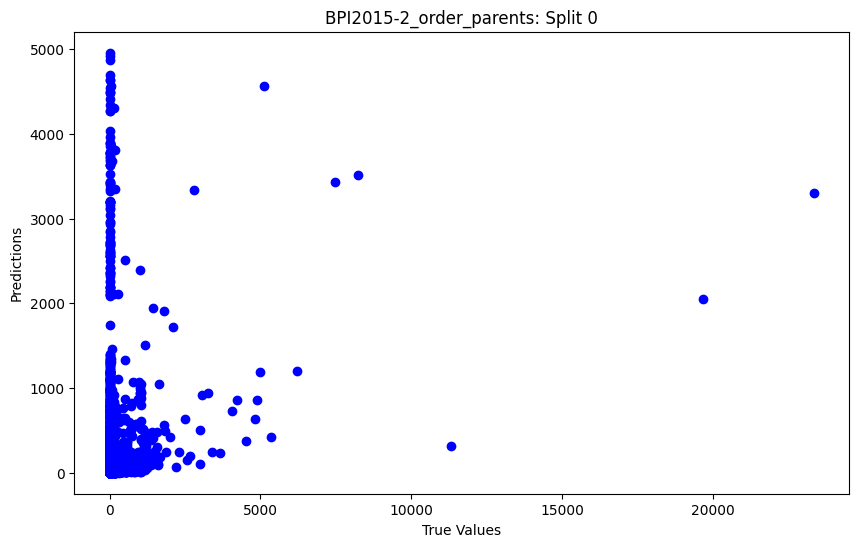

Split 1: 17409 train rows, 8702 test rows
{'mse': 277725.7378622266,
 'rmse': 526.9969049835365,
 'split': 1,
 'time': 0.5033872127532959}


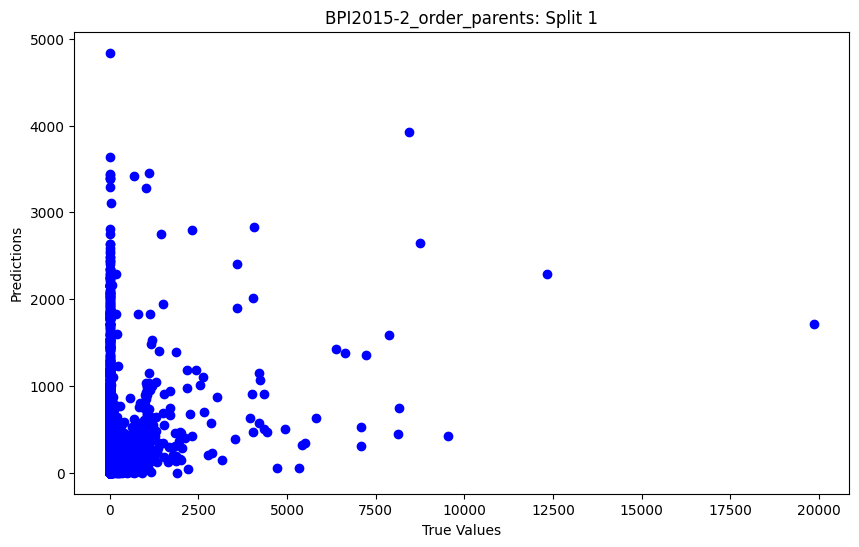

Split 2: 26111 train rows, 8702 test rows
{'mse': 158837.76103509573,
 'rmse': 398.5445533878185,
 'split': 2,
 'time': 0.8566439151763916}


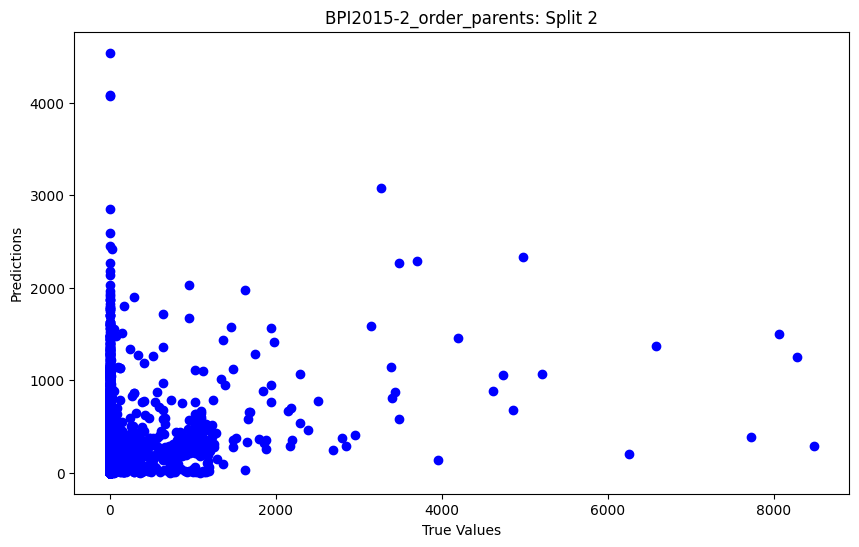

Split 3: 34813 train rows, 8702 test rows
{'mse': 131057.14226785816,
 'rmse': 362.01815184857537,
 'split': 3,
 'time': 1.0888094902038574}


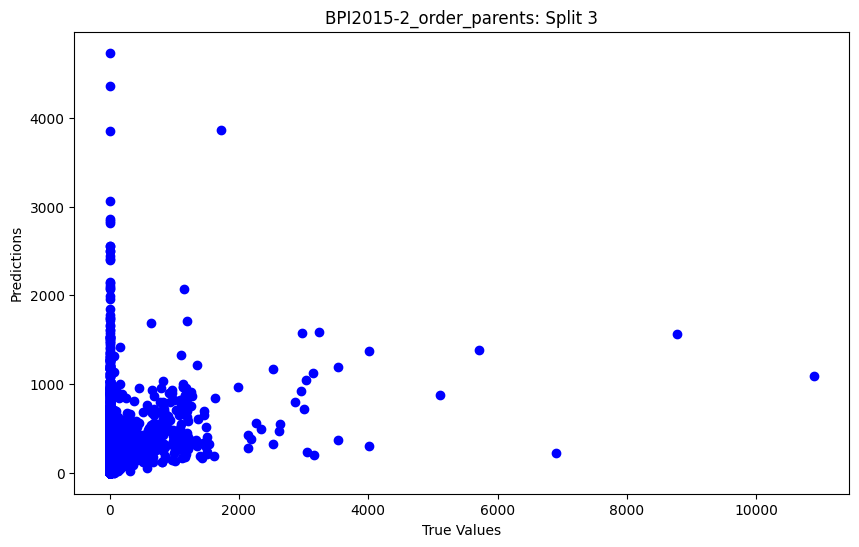

Split 4: 43515 train rows, 8702 test rows
{'mse': 35428.55363304566,
 'rmse': 188.22474235085477,
 'split': 4,
 'time': 1.1355934143066406}


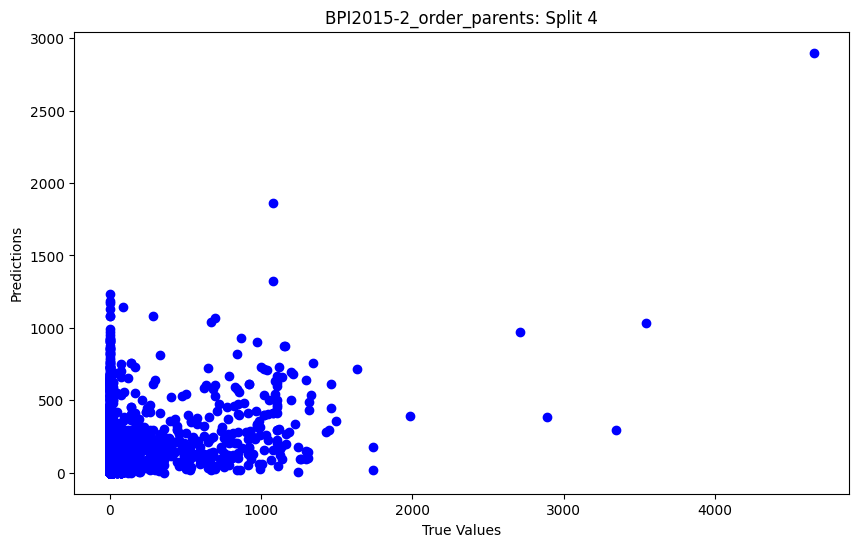

{'mse': 179788.7760882123, 'rmse': 403.9492756981285}


In [44]:
columns = parents_2_order + ["elapsed_time_from_event_timestamp"]

results_2_order_parents = causality.run_experiment(
    dataset,
    target="elapsed_time_from_event_timestamp",
    name="BPI2015",
    experiment="2_order_parents",
    columns=columns,
)